In [35]:
import pandas as pd
import datetime as dt
import pandas_datareader as pdr
import numpy as np
import praw
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from praw.models import MoreComments
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error



In [36]:

pd.set_option('display.width', 999)

stock_symbol = 'MSFT'

# Train / Test split date
stock_date = '2020-01-01'

df = pd.read_csv('msft_with_sentiment.csv', date_parser = True)
df = df.set_index('Date', drop = True)

# Create short simple moving average over the short window
df['short_mavg'] = df['Close'].rolling(window=5, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
df['long_mavg'] = df['Close'].rolling(window=30, min_periods=1, center=False).mean()

# Create signals
df['signal'] = np.where(df['short_mavg'] > df['long_mavg'], 1.0, 0.0)

df.index = pd.to_datetime(df.index)

data_training = df.loc[(df.index <= stock_date)]
data_test = df.loc[(df.index >= stock_date)]

data_test = data_test.reset_index()
data_training = data_training.reset_index()

print(data_training.shape)
print(data_training[(data_training.signal > 0) & (data_training.TwitterSentiment != 0)].head())

data_training = data_training.drop(['Date', 'TwitterSentiment'], axis = 1)
data_training_test = data_training
data_test = data_test.drop(['Date', 'TwitterSentiment'], axis = 1)



(695, 11)
         Date       Open       High        Low      Close  Adj Close    Volume  TwitterSentiment  short_mavg  long_mavg  signal
6  2017-01-11  62.610001  63.230000  62.430000  63.189999  59.109024  21517300         -0.981695   62.717999  62.638571     1.0
7  2017-01-12  63.060001  63.400002  61.950001  62.610001  58.566483  20968200         -0.977989   62.780000  62.635000     1.0
8  2017-01-13  62.619999  62.869999  62.349998  62.700001  58.650673  19422300         -0.479741   62.752000  62.642222     1.0
9  2017-01-17  62.680000  62.700001  62.029999  62.529999  58.491653  20664000         -0.996626   62.730000  62.631000     1.0
10 2017-01-18  62.669998  62.700001  62.119999  62.500000  58.463589  19670100         -0.999345   62.706000  62.619091     1.0


In [51]:
# The values in the training data are not in the same range
# For getting all the values in between the range 0 to 1 use MinMaxScalar() 
# to improves the accuracy of prediction
scaler = MinMaxScaler()
data_training_normalized = scaler.fit_transform(data_training)
print(data_training_normalized)

# This sections of the code divides the data into chunks of 10 rows corresponds to 
# the length of data_traning. After dividing we are converting X_train and y_train
# into numpy arrays
X_train = []
y_train = []

for i in range(10, data_training_normalized.shape[0]):
    X_train.append(data_training_normalized[i-10:i])
    y_train.append(data_training_normalized[i, 8])
    
X_train, y_train = np.array(X_train), np.array(y_train)

print(X_train.shape, y_train.shape)


[[6.16905215e-03 1.85777680e-03 1.86974135e-03 ... 1.95242408e-03
  2.06292592e-03 0.00000000e+00]
 [2.98170888e-03 9.28888401e-04 1.76584606e-03 ... 4.88106019e-04
  5.15731481e-04 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 8.30975382e-04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [9.80567561e-01 9.91536722e-01 9.91482217e-01 ... 9.92824935e-01
  9.92197800e-01 1.00000000e+00]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 9.99623482e-01
  9.96489380e-01 1.00000000e+00]
 [9.95270491e-01 9.94529890e-01 9.84522645e-01 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]]
(685, 10, 9) (685,)


In [53]:
# Build model
model = Sequential()

X_train.shape[1]

model.add(LSTM(units = 60, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(units = 1, activation = 'sigmoid'))

model.summary()

model.compile(optimizer='adam', loss = 'binary_crossentropy')
model.fit(X_train, y_train, epochs=50, batch_size=32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 10, 60)            16800     
_________________________________________________________________
dropout_12 (Dropout)         (None, 10, 60)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 10, 60)            29040     
_________________________________________________________________
dropout_13 (Dropout)         (None, 10, 60)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 10, 80)            45120     
_________________________________________________________________
dropout_14 (Dropout)         (None, 10, 80)            0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 120)               96480     
__________

In [54]:
# Prediction on Signals
# 
#  past_10_days contains the data of the past 10 days required to predict the opening of the 1st day in the test data set.
past_10_days = data_training_test.tail(10)
print(past_10_days)

# We are going to append data_test to past_10_days and ignore the index of data_test
df = past_10_days.append(data_test, ignore_index = True)
print(df.head())

# Similar to the training data set we have to scale the test data so that all the values are in the range 0 to 1.
inputs = scaler.fit_transform(df)
#inputs = np.delete(inputs, [1,2,3,4,5,6,7], axis=1)
print(inputs.shape)


# Prepare the test data like the training data.
X_test = []
y_test = []

for i in range(10, inputs.shape[0]):
    X_test.append(inputs[i-10:i])
    y_test.append(inputs[i, 8])

X_test, y_test = np.array(X_test), np.array(y_test)

print("--------")
print(X_test.shape)

y_pred = model.predict(X_test)

print(y_pred.shape)

# Calcualte the original price back again
scale = 1/scaler.scale_[8]
print(scale)

# Prediction on the normal price scale
y_pred = y_pred*scale
y_test = y_test*scale

           Open        High         Low       Close   Adj Close    Volume  short_mavg   long_mavg  signal
685  155.110001  155.899994  154.820007  155.529999  153.546005  24144200  153.226001  149.535667     1.0
686  155.449997  155.710007  154.449997  154.690002  152.716705  25425600  153.938000  149.873667     1.0
687  154.300003  155.479996  154.179993  154.369995  152.400803  24129200  154.472000  150.204000     1.0
688  154.000000  155.770004  153.750000  155.710007  153.723709  24958900  154.966000  150.592334     1.0
689  157.350006  158.490005  156.289993  157.410004  155.402023  53477500  155.542001  151.030667     1.0
690  158.119995  158.119995  157.270004  157.410004  155.402023  17718200  155.918002  151.412334     1.0
691  157.479996  157.710007  157.119995  157.380005  155.372406   8989200  156.456003  151.788001     1.0
692  157.559998  158.729996  157.399994  158.669998  156.645950  14520600  157.316004  152.174667     1.0
693  159.449997  159.550003  158.220001  158.9

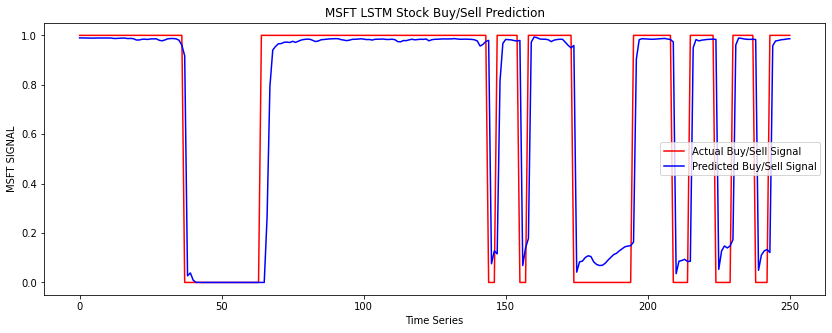

In [55]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Actual Buy/Sell Signal ')
plt.plot(y_pred, color = 'blue', label = 'Predicted Buy/Sell Signal')
plt.title(stock_symbol + ' LSTM Stock Buy/Sell Prediction')
plt.xlabel('Time Series')
plt.ylabel(stock_symbol + ' SIGNAL')
plt.legend()
plt.show()

In [58]:
print("---- SCORE ------")
#test_loss, test_accuracy = model.evaluate(X_test, y_test)

from sklearn.metrics import average_precision_score, confusion_matrix, classification_report
print(average_precision_score(y_test, y_pred))

for x in range(y_pred.size):
    if (y_pred[x] < 0.8):
        y_pred[x] = 0
    else:
        y_pred[x] = 1

cm = confusion_matrix(y_test, y_pred)
print(cm)

class_names = ['Sell', 'Buy']
print(classification_report(y_test, y_pred, target_names=class_names,digits=3))


---- SCORE ------
0.9469341716623776
[[ 64   7]
 [ 10 170]]
              precision    recall  f1-score   support

        Sell      0.865     0.901     0.883        71
         Buy      0.960     0.944     0.952       180

    accuracy                          0.932       251
   macro avg      0.913     0.923     0.918       251
weighted avg      0.933     0.932     0.933       251



In [68]:
train_data, test_data = df[0:int(len(df)*0.7)], df[int(len(df)*0.30):]

training_data = train_data['signal'].values
test_data = test_data['signal'].values

history = [x for x in training_data]

model_predictions = []
N_test_observations = len(test_data)

for time_point in range(N_test_observations):
    model = ARIMA(history, order=(4,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)

for x in range(len(model_predictions)):
    if (model_predictions[x] < 0.8):
        model_predictions[x] = 0
    else:
        model_predictions[x] = 1

cm = confusion_matrix(test_data, model_predictions)
print(cm)

class_names = ['Sell', 'Buy']
print(classification_report(test_data, model_predictions, target_names=class_names,digits=3))


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning

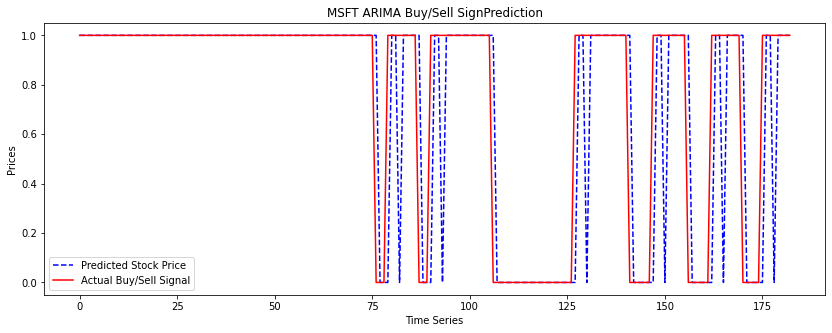

In [69]:
# Visualising the results
test_set_range = df[int(len(df)*0.7):].index

plt.figure(figsize=(14,5))
plt.plot(model_predictions, color='blue', linestyle='dashed',label='Predicted Stock Price')
plt.plot(test_data, color='red', label='Actual Buy/Sell Signal')
plt.title('MSFT ARIMA Buy/Sell SignPrediction')
plt.xlabel('Time Series')
plt.ylabel('Prices')
plt.legend()
plt.show()

                  Date        Open        High         Low       Close   Adj Close    Volume  TwitterSentiment  short_mavg   long_mavg    y         ds
Date                                                                                                                                                  
2017-01-03  2017-01-03   62.790001   62.840000   62.130001   62.580002   58.538418  20694100          0.499253   62.580002   62.580002  0.0 2017-01-03
2017-01-04  2017-01-04   62.480000   62.750000   62.119999   62.299999   58.276497  21340000         -0.995186   62.440000   62.440000  0.0 2017-01-04
2017-01-05  2017-01-05   62.189999   62.660000   62.029999   62.299999   58.276497  24876000          0.318698   62.393333   62.393333  0.0 2017-01-05
2017-01-06  2017-01-06   62.299999   63.150002   62.040001   62.840000   58.781628  19922900         -0.348997   62.505000   62.505000  0.0 2017-01-06
2017-01-09  2017-01-09   62.759998   63.080002   62.540001   62.639999   58.594547  20382700  

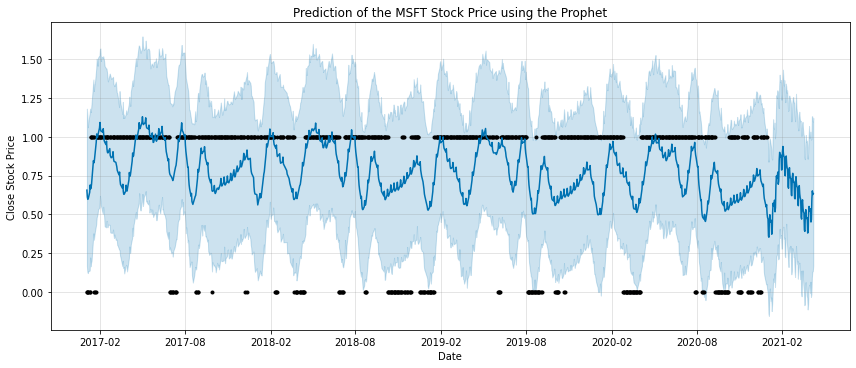

             ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  additive_terms  additive_terms_lower  additive_terms_upper     daily  daily_lower  daily_upper    weekly  weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  multiplicative_terms  multiplicative_terms_lower  multiplicative_terms_upper      yhat
0    2017-01-03  0.164731    0.167647    1.182184     0.164731     0.164731        0.491563              0.491563              0.491563  0.660011     0.660011     0.660011  0.068651      0.068651      0.068651 -0.237099     -0.237099     -0.237099                   0.0                         0.0                         0.0  0.656294
1    2017-01-04  0.164626    0.128534    1.139824     0.164626     0.164626        0.445923              0.445923              0.445923  0.660011     0.660011     0.660011  0.027315      0.027315      0.027315 -0.241403     -0.241403     -0.241403                   0.0                         0.0                         0.0  0

In [33]:
from fbprophet import Prophet

df = pd.read_csv('msft_with_sentiment.csv', date_parser = True)


# Create short simple moving average over the short window
df['short_mavg'] = df['Close'].rolling(window=5, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
df['long_mavg'] = df['Close'].rolling(window=30, min_periods=1, center=False).mean()

# Create signals
df['signal'] = np.where(df['short_mavg'] > df['long_mavg'], 1.0, 0.0)

df.index = pd.to_datetime(df['Date'])

df.rename(columns={'signal': 'y'},inplace=True)
df['ds'] = pd.to_datetime(df.index)

print(df)

m = Prophet(daily_seasonality = True) # the Prophet class (model)
m.fit(df) # fit the model using training data

future = m.make_future_dataframe(periods=100) #we need to specify the number of days in future
prediction = m.predict(future)
m.plot(prediction, figsize=(12, 5))
plt.title("Prediction of the MSFT Stock Price using the Prophet")
plt.xlabel("Date")
plt.ylabel("Close Stock Price")
plt.show()
